# Task 3

## Task 3.1

In [ ]:
import torch
import matplotlib.pyplot as plt
import xarray as xr
from scipy.spatial import Delaunay
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from dataclasses import dataclass
from model.gaot import GAOT
from model.layers.magno import MAGNOConfig
from model.layers.attn import TransformerConfig
from torch.utils.data import Dataset
from collections import defaultdict

### Model definition

In [3]:
# Configuration dataclass
@dataclass
class ModelArgs:
    magno: MAGNOConfig
    transformer: TransformerConfig


@dataclass
class GAOTConfig:
    latent_tokens_size: list
    args: ModelArgs


# Create configuration based on user requirements
magno_config = MAGNOConfig(
    coord_dim=2,
    radius=0.033,
    hidden_size=64,
    mlp_layers=3,
    lifting_channels=64,
    precompute_edges=False,
)

transformer_config = TransformerConfig(
    patch_size=2,
    hidden_size=256
)

model_args = ModelArgs(
    magno=magno_config,
    transformer=transformer_config
)

config = GAOTConfig(
    latent_tokens_size=[64, 64],
    args=model_args
)


# Create coordinate grid for 64x64 regular grid
def create_coordinate_grid(height=64, width=64):
    """
    Create a regular 2D coordinate grid.

    Returns:
        coords: torch.Tensor of shape [height*width, 2]
                Coordinates normalized to [0, 1] x [0, 1]
    """
    y = torch.linspace(-1, 1, height)
    x = torch.linspace(-1, 1, width)

    grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')

    # Flatten and stack to get [N, 2] coordinates
    coords = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

    return coords


# Create coordinate grids (fixed for all samples)
coord_grid = create_coordinate_grid(64, 64)
latent_tokens_coord = create_coordinate_grid(64, 64)

# Initialize GAOT model
model = GAOT(
    input_size=1,  # input has 1 channel
    output_size=1,  # output has 1 channel
    config=config
)

print(f"Model initialized: GAOT")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Using torch_cluster for efficient neighbor search
Using torch_cluster for efficient neighbor search
Model initialized: GAOT
Number of parameters: 3396033


In [4]:
class ElasticityDataset(Dataset):
    def __init__(self, path, split="train", train_ratio=0.9):
        super().__init__()

        # Extract data
        ds = xr.open_dataset(path)

        # 1. Extract and Squeeze sub values c, u and x
        inputs_c = ds["c"].values.squeeze() 
        outputs_u = ds["u"].values.squeeze()
        coords_x = ds["x"].values.squeeze()

        n_samples = inputs_c.shape[0]
        n_train = int(train_ratio * n_samples)

        # Split between train data and validation data
        if split == "train":
            self.c = inputs_c[:n_train]
            self.u = outputs_u[:n_train]
            self.x = coords_x[:n_train]
        elif split == "val":
            self.c = inputs_c[n_train:]
            self.u = outputs_u[n_train:]
            self.x = coords_x[n_train:]
        else:
            raise ValueError("split must be 'train' or 'val'")
        
        # Convert to float32 tensors
        self.c = torch.tensor(self.c, dtype=torch.float32)
        self.u = torch.tensor(self.u, dtype=torch.float32)
        self.x = torch.tensor(self.x, dtype=torch.float32)

    def __len__(self):
        return self.c.shape[0]

    def __getitem__(self, idx):
        # Return dictionary. 
        return {
            "input": self.c[idx], 
            "coords": self.x[idx], 
            "output": self.u[idx],
        }

In [5]:
batch_size = 16

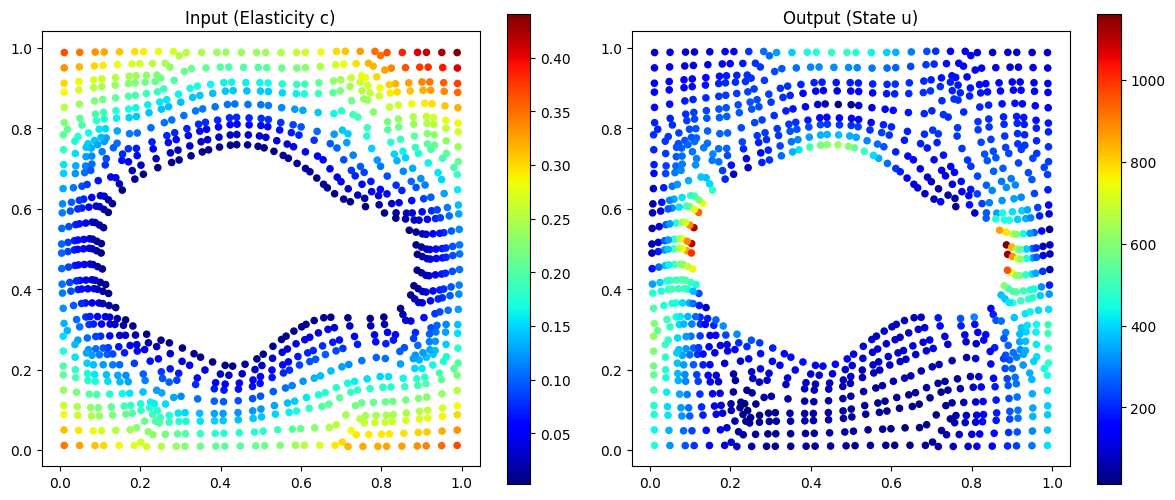

In [6]:
# Retrieve triain and validation dataset
train_dataset = ElasticityDataset(path="data/Elasticity.nc",split="train")
val_dataset = ElasticityDataset(path="data/Elasticity.nc",split="val")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

batch = next(iter(train_loader))
# Indices: [0] for first sample in batch, then convert to numpy
coords = batch["coords"][0].numpy()
input = batch["input"][0].numpy()
output = batch["output"][0].numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Input (Elasticity 'c')
im1 = axes[0].scatter(coords[:, 0], coords[:, 1], c=input, cmap="jet", s=20)
axes[0].set_title("Input (Elasticity c)")
axes[0].set_aspect('equal')
fig.colorbar(im1, ax=axes[0])

# Plot Output (State 'u')
im2 = axes[1].scatter(coords[:, 0], coords[:, 1], c=output, cmap="jet", s=20)
axes[1].set_title("Output (State u)")
axes[1].set_aspect('equal')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


### Training loop

In [7]:
def training(encoder_nbrs=None):
    optimizer = AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=200, eta_min=10**-6)
    l = torch.nn.L1Loss()

    num_epochs = 20

    freq_print = 1
    for epoch in range(num_epochs):
        model.train()
        train_mse = 0.0
        for step, (batch) in enumerate(train_loader):
            coords = batch["coords"][0]
            input = batch["input"].unsqueeze(-1)
            output = batch["output"].unsqueeze(-1)

            optimizer.zero_grad()

            # Forward pass through GAOT
            # In fx mode (fixed coordinates), xcoord and latent_tokens_coord don't need batch dimension
            pred = model(
                latent_tokens_coord=latent_tokens_coord,    # [N, 2]
                xcoord=coords,                              # [N, 2]
                pndata=input,                               # [batch, N, 1]
                query_coord=None,                           # Use xcoord as query
                encoder_nbrs=encoder_nbrs,                  # Compute neighbors on-the-fly
                decoder_nbrs=None,
                condition=None
            )

            # Compute loss
            loss_f = l(pred, output) / l(output, torch.zeros_like(output))
            loss_f.backward()
            optimizer.step()
            train_mse += loss_f.item()
        train_mse /= len(train_loader)

        scheduler.step()
        with torch.no_grad():
            model.eval()
            test_relative_l1 = 0.0
            for step, (batch) in enumerate(val_loader):

                coords = batch["coords"][0]
                input = batch["input"].unsqueeze(-1)
                output = batch["output"].unsqueeze(-1)

                pred = model(
                    latent_tokens_coord=latent_tokens_coord,
                    xcoord=coords,
                    pndata=input,
                    query_coord=None,
                    encoder_nbrs=encoder_nbrs,
                    decoder_nbrs=None,
                    condition=None
                )

                loss_f = (torch.mean((abs(pred - output))) / torch.mean(abs(output))) * 100
                test_relative_l1 += loss_f.item()
            test_relative_l1 /= len(val_loader)

        if epoch % freq_print == 0:
            print("## Epoch:", epoch, " ## Train Loss:", train_mse, "## Rel L1 Test Norm:", test_relative_l1, "LR: ", scheduler.get_last_lr())


### Plot results

In [8]:
def evaluation(encoder_nbrs=None):
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))

        # Reshape for GAOT model
        coords = batch["coords"][0:1]
        input = batch["input"][0:1].unsqueeze(-1)
        output = batch["output"][0:1].unsqueeze(-1)

        pred = model(
                    latent_tokens_coord=latent_tokens_coord,
                    xcoord=coords,
                    pndata=input,
                    query_coord=None,
                    encoder_nbrs=encoder_nbrs,
                    decoder_nbrs=None,
                    condition=None
                )

        # Reshape back to image format
        # pred = pred.reshape(batch_size, 1, 64, 64)

        # Convert to numpy for visualization
        coords = coords.squeeze(0).numpy()
        input = input.squeeze().numpy()
        output = output.squeeze().numpy()
        pred = pred.squeeze().numpy()

    vmin, vmax = pred.min(), pred.max()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].scatter(coords[:, 0], coords[:, 1], c=input, cmap="jet", s=20)
    axes[0].set_title("Input")

    axes[1].scatter(coords[:, 0], coords[:, 1], c=output, cmap="jet", s=20, vmin=vmin, vmax=vmax)
    axes[1].set_title("Ground Truth")

    axes[2].scatter(coords[:, 0], coords[:, 1], c=pred, cmap="jet", s=20, vmin=vmin, vmax=vmax)
    axes[2].set_title("Prediction")
    plt.tight_layout()
    plt.show()

Train and plot results with Strategy I (Structured Stencil Grid)

In [10]:
# Train with structured stencil
training()
evaluation()

KeyboardInterrupt: 

## Task 3.2

In [11]:
N = 64*64
torch.manual_seed(42)
latent_tokens_coord = torch.rand(N, 2) # Define (x,y) N tuples of points
# Define triangulation
tri = Delaunay(latent_tokens_coord)

In [12]:
def build_csr_neighbors(neighbors_per_query):
    """
    neighbors_per_query: List[Tensor], length = num_queries
                          each Tensor is [num_neighbors_l]
    """
    neighbors_index = torch.cat(neighbors_per_query, dim=0)

    row_splits = [0]
    for nbrs in neighbors_per_query:
        row_splits.append(row_splits[-1] + nbrs.numel())

    neighbors_row_splits = torch.tensor(row_splits, dtype=torch.long)

    return {
        "neighbors_index": neighbors_index,
        "neighbors_row_splits": neighbors_row_splits
    }


In [13]:
omega = 1.0  # Scaling factor, can be adjusted

In [37]:
# Build neighbors list from Delaunay triangulation
neighbors = defaultdict(list)
for simplex in tri.simplices:
    for i in range(3):
        for j in range(i+1, 3):
            p1, p2 = simplex[i], simplex[j]
            if p2 not in neighbors[p1]:
                neighbors[p1].append(p2)
            if p1 not in neighbors[p2]:
                neighbors[p2].append(p1)

# Compute local radius r_l for each token
r_l = torch.zeros(N)
for l in range(N):
    nbrs = neighbors[l]
    if nbrs:
        dists = torch.norm(latent_tokens_coord[l] - latent_tokens_coord[nbrs], dim=1)
        d_k = torch.max(dists)  # Use max distance to ensure coverage of all Delaunay neighbors
        r_l[l] = omega * d_k
    else:
        r_l[l] = 0.0  # Fallback, though unlikely in a connected triangulation

# r_l is now a tensor of shape [N] containing the local radii
print(f"Local radii computed: min={r_l.min().item():.4f}, max={r_l.max().item():.4f}")

neighbors_per_latent = []
coords_torch = torch.from_numpy(coords)

for l in range(N):
    dist = torch.norm(coords_torch - latent_tokens_coord[l], dim=1)  # coords = physical nodes
    mask = (dist <= r_l[l])
    nbrs_l = torch.nonzero(mask, as_tuple=False).squeeze(1)

    # Avoid empty rows
    if nbrs_l.numel() == 0:
        nbrs_l = torch.argmin(dist).unsqueeze(0)

    neighbors_per_latent.append(nbrs_l)

neighbors = [build_csr_neighbors(neighbors_per_latent)]

Local radii computed: min=0.0028, max=0.8565


Redefine model for unstructured grid

In [38]:
magno_config = MAGNOConfig(
    coord_dim=2,
    radius=r_l.max(),
    hidden_size=64,
    mlp_layers=3,
    lifting_channels=64,
    precompute_edges=True,
)
model = GAOT(
    input_size=1,  # input has 1 channel
    output_size=1,  # output has 1 channel
    config=config
)

Using torch_cluster for efficient neighbor search
Using torch_cluster for efficient neighbor search


In [39]:
training(neighbors)
evaluation(neighbors)

KeyboardInterrupt: 